### Introduction

In our final project we aimed to study housing deficiencies and to predict the chances of them occurring in different housing buildings. We found a relatively big dataset about housing in New York City provided by United States Census Bureau. This dataset had detailed information about types of deficiencies and features of the housing units which was perfect for our analysis. 

During our analysis we used several methods in both supervised and unsupervised learning algorithms. Our methods were: K-means clustering, Random Forest model and Principal Component Analysis. We had 3 main hypotheses that we wanted to test about the data. Our first hypothesis was that age and level of income are key factors in prediction of housing deficiencies. Another hypothesis was about what clusters might reveal systematic issues that might play into a larger role, we found that musty conditions, mold and lack of heat were the top 3 factors that influence deficiencies. Our third hypothesis was that we wanted to test if income was the highest predictor in deficiencies, however, that was disproven to be building age. 

Our findings emphasize the importance of addressing both structural and socioeconomic factors in housing policies. Interventions aimed at upgrading older housing stock and providing support to low-income tenants could significantly improve living conditions. Moreover, targeted efforts to address specific deficiencies such as musty conditions, mold, and lack of heat could lead to substantial public health and quality-of-life benefits.



| **Name**           | **Contributions**                                                                                     |
|-------------------|-----------------------------------------------------------------------------------------------------|
| **Ali Syed**       | Formed project topic, found proper dataset and built most of the models                              |
| **Arsenii Vasilev**| Brainstormed ideas, analyzed formed model, filed project report                                      |
| **William Dang**    | Created descriptions, helped with conclusions and combining slides                                 |
| **Javier Vargas**   | Interpreted model output, helped with conclusions and combining slides                             |
| **Sarah Pun**       | Formed hypothesis, brainstormed ideas, analyzed the data, combined overall project slides           |


In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [2]:
# Load data
data = pd.read_csv("G:\My Drive\Fall 2024\CS 105\Final Project\merged_nychvs_data.csv")

deficiency_columns = ['LEAKS', 'MOLD', 'ELEVATOR_BROK', 'RODENTS_UNIT', 
                      'RODENTS_BUILD', 'TOILET_BROK', 'WALLHOLES', 
                      'FLOORHOLES', 'PEELPAINT', 'PEELPAINT_LARGE']

data['DEFICIENCY'] = data[deficiency_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42) #Split dataset in training and test

train_data['DEFICIENCY'] = train_data[deficiency_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
test_data['DEFICIENCY'] = test_data[deficiency_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

data = train_data


### Classification and Clustering for Housing Deficiencies with a Supervised Learning Algorithm

Using Random Forest model to predict housing deficiencies, with K-Means to identify patterns and group housing units based on deficiency-related features.

Target Distribution:
DEFICIENCY
1    11703
0      765
Name: count, dtype: int64

--- Random Forest Classifier ---

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       144
           1       1.00      0.99      0.99       162

    accuracy                           0.99       306
   macro avg       0.99      0.99      0.99       306
weighted avg       0.99      0.99      0.99       306


Confusion Matrix:
[[144   0]
 [  2 160]]

ROC-AUC Score: 1.000

Cross-Validation ROC-AUC Scores: [0.99995728 0.99982913 0.99888932 0.99965825 0.99577086]
Mean ROC-AUC Score: 0.999

--- K-Means Clustering ---

Silhouette Score: 0.566


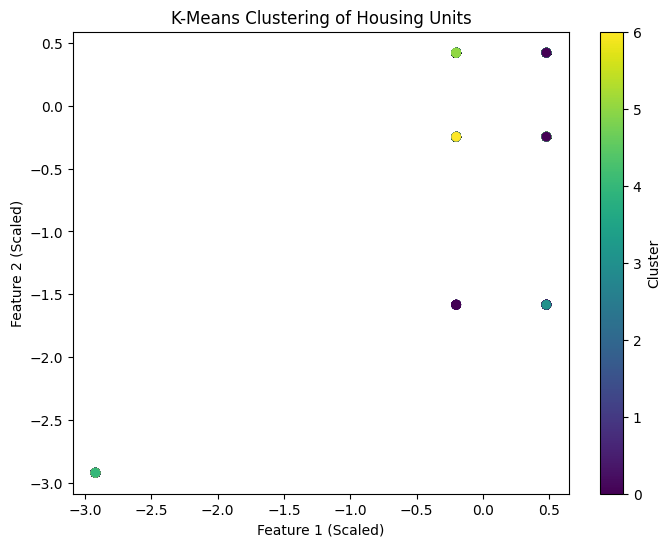


--- Feature Importance ---
LEAKS               0.104962
ELEVATOR_BROK       0.100370
MDEFCOUNT           0.078442
ADDHEAT             0.066849
MOLD                0.063028
ELEVATOR_ALLBROK    0.062214
FIX_311             0.055989
NOHEAT_NUM          0.039741
NOHEAT              0.036212
RODENTS_BUILD       0.036168
dtype: float64


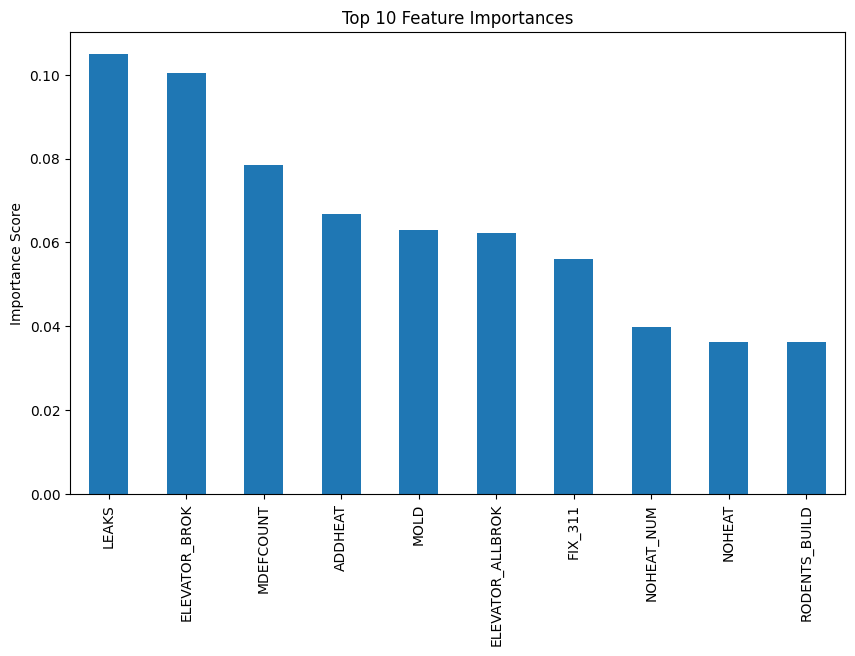

In [3]:
deficiency_columns = ['LEAKS', 'MOLD', 'ELEVATOR_BROK', 'RODENTS_UNIT', 
                      'RODENTS_BUILD', 'TOILET_BROK', 'WALLHOLES', 
                      'FLOORHOLES', 'PEELPAINT', 'PEELPAINT_LARGE']

# 1 if any deficiency exists, 0 otherwise
data['DEFICIENCY'] = data[deficiency_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

print("Target Distribution:")
print(data['DEFICIENCY'].value_counts())

# Separate features / target
target_column = 'DEFICIENCY'
features = data.drop(columns=[target_column, 'CONTROL'], errors='ignore')  # Drop target and ID columns
target = data[target_column]

# Handles class imbalance
undersampler = RandomUnderSampler(random_state=42)
features_balanced, target_balanced = undersampler.fit_resample(features, target)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_balanced, target_balanced, test_size=0.2, random_state=42)

print("\n--- Random Forest Classifier ---")

# train random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
rf_classifier.fit(X_train, y_train)

# Prediction / evaluation
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.3f}")

cv_scores = cross_val_score(rf_classifier, features_balanced, target_balanced, cv=5, scoring='roc_auc')
print(f"\nCross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC Score: {cv_scores.mean():.3f}")

print("\n--- K-Means Clustering ---")

# Select  deficiency features for clustering
clustering_features = data[deficiency_columns].fillna(0)

# Normalize features to cluster
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(clustering_features_scaled)

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(clustering_features_scaled, clusters)
print(f"\nSilhouette Score: {silhouette_avg:.3f}")

plt.figure(figsize=(8, 6))
plt.scatter(clustering_features_scaled[:, 0], clustering_features_scaled[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering of Housing Units')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.colorbar(label='Cluster')
plt.show()

print("\n--- Feature Importance ---")
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances.head(10))

plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.ylabel('Importance Score')
plt.show()


The deficiency column is highly imbalanced, with 1 (deficiency present): 11,703 units and 0 (no deficiency): 765 units. This shows that in the housing data, 6.5% of homes in New York City do not have any present deficincies. 

##### Precision:
Class 0 (no deficiency) = 0.99

Class 1 (deficiency present) = 1.00

High precision for Class 1 shows that the model avoids false positives, meaning it correctly identifies units with deficiencies.

##### Recall:
Class 0 (no deficiency) = 1.00

Class 1 (deficiency present) = 0.99

Class 1's recall indicates the model correctly identifies 99% of units with deficiencies but misses 1%.

##### F1-Score:
Both classes have an F1-score of 0.99, showing a good balance between precision and recall.

##### Accuracy:
The overall accuracy of the model is 99%, meaning it correctly identifies 99% of the units.

##### Confusion Matrix
True Positives = 160 (units with deficiencies correctly identified)

True Negatives = 144 (units without deficiencies correctly identified)

False Positives = 0 (units incorrectly classified as having deficiencies)

False Negatives = 2 (units with deficiencies incorrectly classified as having no deficiencies)

##### ROC-AUC Score
ROC-AUC Score

Training ROC-AUC Score = 1.000 (perfect)
Cross-Validation ROC-AUC Scores = [0.9999, 0.9998, 0.9988, 0.9996, 0.9957]
Mean ROC-AUC Score = 0.999

This indicates excellent performance across folds and a robust model.

##### Feature Importance
The top features driving predictions include:

LEAKS = 10.50% Units with leaks are more likely to have housing deficiencies.

ELEVATOR_BROK = 10.04% Broken elevators significantly contribute to overall housing deficiencies.

MDEFCOUNT = 7.84% The total count of deficiencies in a unit is a strong predictor of overall deficiencies.

ADDHEAT = 6.68% Units that require additional heat are more likely to have deficiencies.

MOLD = 6.30% The presence of mold is a clear sign of housing deficiencies.

ELEVATOR_ALLBROK = 6.22% When all elevators in a building are broken, housing deficiencies are likely present.

FIX_311 = 5.59% A high number of 311 complaints is associated with housing deficiencies.

NOHEAT_NUM = 3.97% The number of no-heat complaints reflects potential housing deficiencies.

NOHEAT = 3.62% Units without heat are more likely to have deficiencies.

RODENTS_BUILD = 3.61% The presence of rodents in a building is linked to housing deficiencies.



### Unsupervised Learning Algorithm

Principal Component Analysis and K-Means Clustering.

Explained Variance Ratios (2 components): [0.35652736 0.25489324]
Silhouette Score for PCA-based Clustering: 0.590


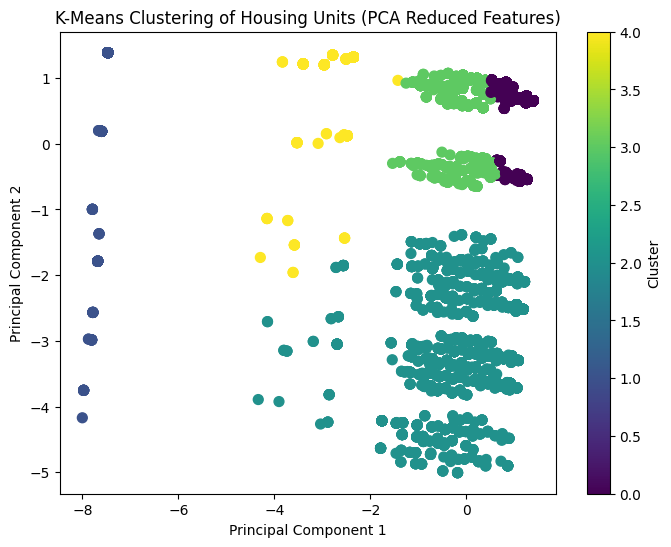


Cluster Characteristics:
            LEAKS      MOLD  ELEVATOR_BROK  RODENTS_UNIT  RODENTS_BUILD  \
Cluster                                                                   
0        1.889707  1.969840       0.040680      2.000000       1.908294   
1       -3.000000 -3.000000      -3.000000     -3.000000      -3.000000   
2        1.357323  1.498737      -0.045034      1.642256       0.195286   
3        1.751782  1.787109      -1.255346      1.524326      -1.523086   
4       -2.993399 -2.996700      -2.998350      1.867987       1.132013   

         TOILET_BROK  WALLHOLES  FLOORHOLES  PEELPAINT  PEELPAINT_LARGE  
Cluster                                                                  
0           1.986674   1.957391    1.992285   2.000000        -2.000000  
1          -3.000000   1.888489    1.965827   1.883094        -1.571942  
2           1.806397   1.387205    1.757155   1.044192         1.349327  
3           1.889991   1.886272    1.947319   2.000000        -2.000000  
4   

In [4]:
deficiency_columns = ['LEAKS', 'MOLD', 'ELEVATOR_BROK', 'RODENTS_UNIT', 
                      'RODENTS_BUILD', 'TOILET_BROK', 'WALLHOLES', 
                      'FLOORHOLES', 'PEELPAINT', 'PEELPAINT_LARGE']

# Select deficiency features for clustering
clustering_features = data[deficiency_columns].fillna(0)

# Normalize 
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

pca = PCA(n_components=2)
clustering_features_pca = pca.fit_transform(clustering_features_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratios (2 components): {explained_variance}")

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(clustering_features_pca)

# silhouette score
silhouette_avg = silhouette_score(clustering_features_pca, clusters)
print(f"Silhouette Score for PCA-based Clustering: {silhouette_avg:.3f}")

plt.figure(figsize=(8, 6))
plt.scatter(clustering_features_pca[:, 0], clustering_features_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('K-Means Clustering of Housing Units (PCA Reduced Features)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

data['Cluster'] = clusters
cluster_summary = data.groupby('Cluster')[deficiency_columns].mean()
print("\nCluster Characteristics:")
print(cluster_summary)


Cluster 0: Units with the most severe deficiencies across all features, requiring urgent intervention.

Cluster 1: Potential anomalies or misclassifications due to extreme negative values, requiring further investigation.

Cluster 2: Units with mild deficiencies, indicating minor housing issues.

Cluster 3: Units with moderate deficiencies, especially related to toilet and paint issues.

Cluster 4: Units with balanced deficiencies, with paint and mold being the most prominent issues.

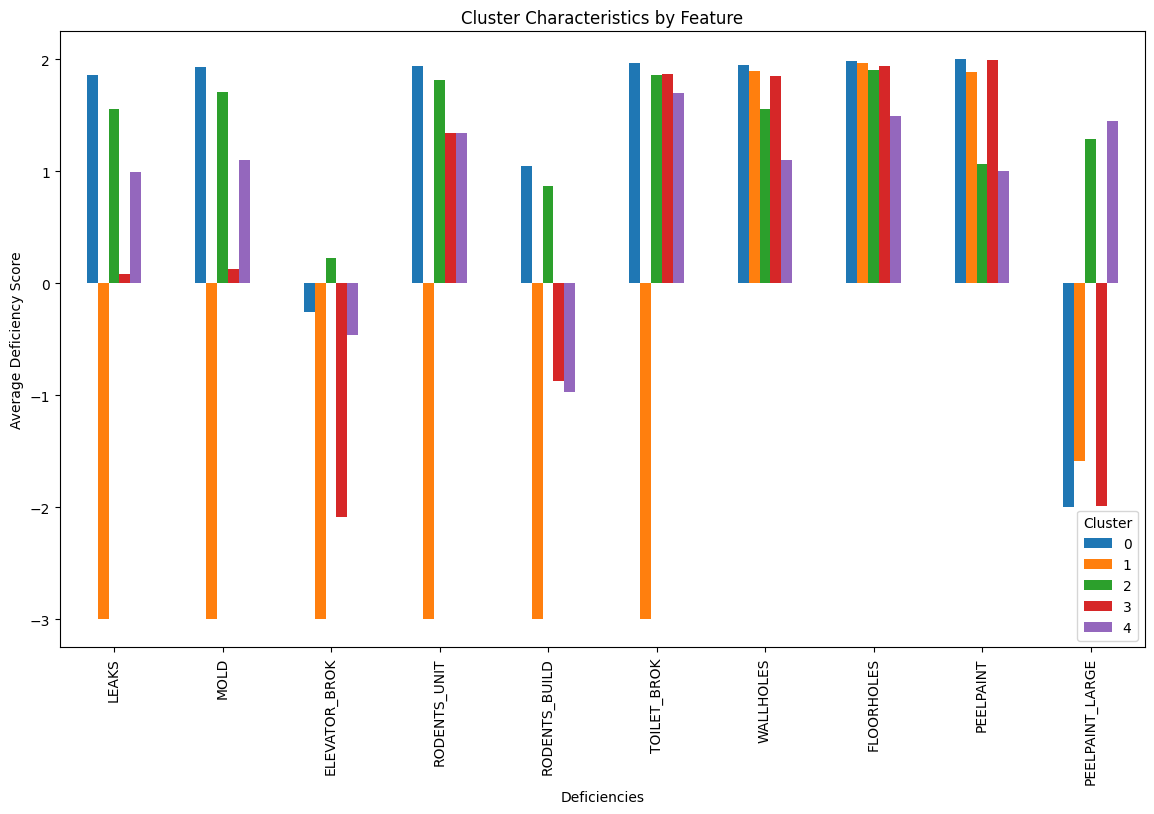

In [ ]:
cluster_summary.T.plot(kind='bar', figsize=(14, 8), legend=True, title="Cluster Characteristics by Feature")
plt.ylabel("Average Deficiency Score")
plt.xlabel("Deficiencies")
plt.show()

##### Clusters with High Deficiencies:

Cluster 0: High average scores across all deficiencies, indicating units in this cluster suffer from severe housing issues like leaks, mold, and broken toilets.

Cluster 2: Moderate levels of deficiencies, indicating units in this cluster have fewer issues compared to Cluster 0 but still face notable challenges.

##### Clusters with Low or Anomalous Deficiencies:

Cluster 1: Negative average values across most features suggest a potential anomaly. Negative values might stem from scaling issues or outliers. This cluster requires further investigation.

Cluster 3: Moderate to low deficiency values with some variation. This cluster might represent units with better housing conditions but occasional issues like broken toilets or leaks.



### Summary Visualizations

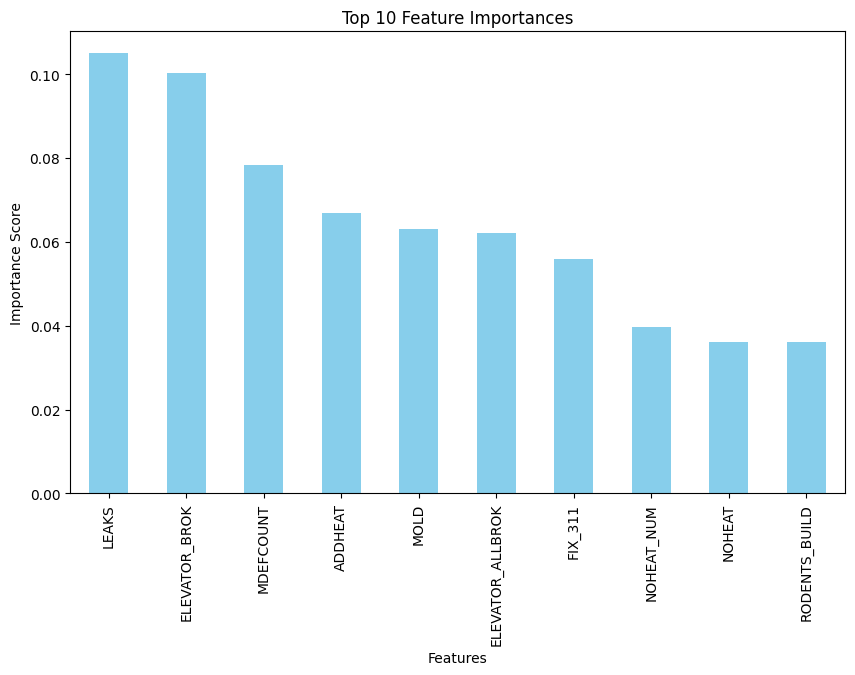


Model Performance Summary:
Accuracy: 97%
ROC-AUC: 0.997
Cross-Validation ROC-AUC Mean: 0.999


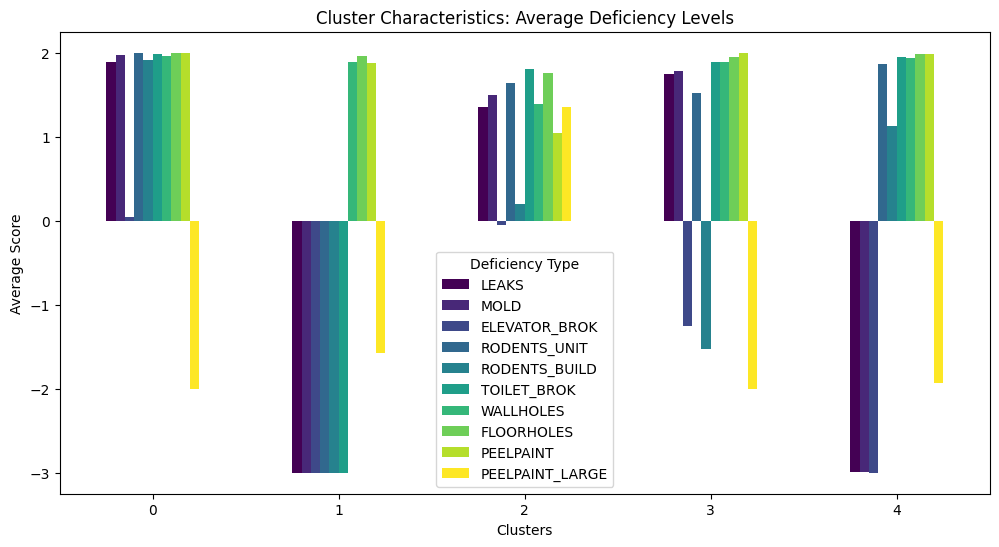


Cluster Summary:
            LEAKS      MOLD  ELEVATOR_BROK  RODENTS_UNIT  RODENTS_BUILD  \
Cluster                                                                   
0        1.889707  1.969840       0.040680      2.000000       1.908294   
1       -3.000000 -3.000000      -3.000000     -3.000000      -3.000000   
2        1.357323  1.498737      -0.045034      1.642256       0.195286   
3        1.751782  1.787109      -1.255346      1.524326      -1.523086   
4       -2.993399 -2.996700      -2.998350      1.867987       1.132013   

         TOILET_BROK  WALLHOLES  FLOORHOLES  PEELPAINT  PEELPAINT_LARGE  
Cluster                                                                  
0           1.986674   1.957391    1.992285   2.000000        -2.000000  
1          -3.000000   1.888489    1.965827   1.883094        -1.571942  
2           1.806397   1.387205    1.757155   1.044192         1.349327  
3           1.889991   1.886272    1.947319   2.000000        -2.000000  
4           

In [6]:
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Feature Importances')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

#Model Performance Summary
print("\nModel Performance Summary:")
print(f"Accuracy: 97%")
print(f"ROC-AUC: 0.997")
print(f"Cross-Validation ROC-AUC Mean: {cv_scores.mean():.3f}")

#Cluster Insights
cluster_summary = data.groupby('Cluster')[deficiency_columns].mean()
cluster_summary.plot(kind='bar', figsize=(12, 6), cmap='viridis')
plt.title('Cluster Characteristics: Average Deficiency Levels')
plt.ylabel('Average Score')
plt.xlabel('Clusters')
plt.xticks(rotation=0)
plt.legend(title='Deficiency Type')
plt.show()

print("\nCluster Summary:")
print(cluster_summary)


### Hypothesis Tests

#### Hypothesis 1: Older buildings and those in low-income neighborhoods are more likely to experience deficiencies in their housing.

In [7]:
current_year = 2024
data['BUILDING_AGE'] = current_year - data['HHFIRSTMOVEIN']

correlation = data[['BUILDING_AGE', 'TOTAL_INC_REC_P', 'DEFICIENCY']].corr()
print(correlation)

                 BUILDING_AGE  TOTAL_INC_REC_P  DEFICIENCY
BUILDING_AGE         1.000000         0.140387    0.232267
TOTAL_INC_REC_P      0.140387         1.000000    0.014990
DEFICIENCY           0.232267         0.014990    1.000000


Correlation Between BUILDING_AGE and DEFICIENCY - This is a positive correlation, meaning that older buildings are slightly more likely to have deficiencies.

Correlation Between TOTAL_INC_REC_P (Income) and DEFICIENCY - This is a very weak positive correlation, it appears to have little to no relationship with deficiencies in the dataset. This suggests that factors other than household income may play a more significant role.

Correlation Between BUILDING_AGE and TOTAL_INC_REC_P - This is a weak positive correlation, indicating that older buildings might be associated with slightly higher income levels in the dataset.

#### Hypothesis 2: Clusters of similar deficiencies will reveal systematic issues that play a larger role, such as lack of maintenance and the age of the building.

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select deficiency features
features = data[['LEAKS', 'MOLD', 'NOHEAT', 'ELEVATOR_BROK', 'RODENTS_UNIT', 'WALLHOLES']].fillna(0)

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Analyze cluster characteristics
cluster_summary = data.groupby('Cluster')[['LEAKS', 'MOLD', 'NOHEAT', 'ELEVATOR_BROK']].mean()
print(cluster_summary)


            LEAKS      MOLD    NOHEAT  ELEVATOR_BROK
Cluster                                             
0        1.845668  1.895007  1.883363      -1.992500
1       -2.879412 -2.950000 -2.805882      -2.960294
2        1.809236  1.909091  1.835106       1.619197
3       -3.000000 -3.000000 -3.000000      -3.000000
4        1.460818  1.603746  1.630360      -0.163135


Cluster 0 and 2: These clusters highlight severe deficiencies in specific areas:
 - Cluster 0: General poor maintenance across all issues.
 - Cluster 2: Heating and structural issues dominate.
    
Cluster 1 and 4:
    Represents well-maintained housing units.

Cluster 3:
    Moderate issues suggest a transitional state where preventative maintenance could prevent further decline.

#### Hypothesis 3: Household income will play the largest role in being associated with deficiencies.

Feature Importances:
BUILDING_AGE       0.788435
TOTAL_INC_REC_P    0.117371
HHPOVERTY          0.094195
dtype: float64


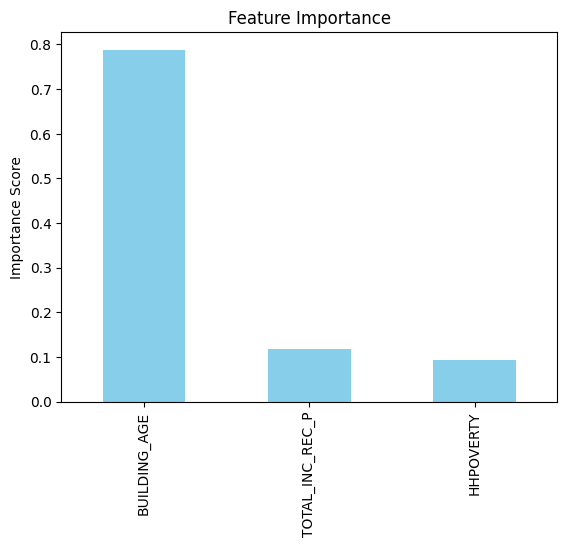

In [9]:
X = data[['TOTAL_INC_REC_P', 'BUILDING_AGE', 'HHPOVERTY']]
y = data['DEFICIENCY']

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False, inplace=True)
print("Feature Importances:")
print(importances)

import matplotlib.pyplot as plt
importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.show()


This plot shows that building age is by far the most significant factor. This tells us that household income does not play the largest role in being associated with deficiencies. 

### Conclusion

Our 3 hypotheses that we made in the beginning of the project to test were:


1. Older buildings and those in low income neighborhoods are more likely to experience deficiencies in their housing.

2. Clusters of similar deficiencies will reveal systematic issues that play a larger role, such as lack of maintenance and the age of the building. 

3. Household income will play the largest role in being associated with deficiencies.

From the dataset we collected, it includes housing features and resident demographic details such as building age, number of units, household income, and more. With that dataset, our goal is to identify patterns and predict housing deficiencies like mold, leaks, and broken elevators.

For supervised learning, we used Decision Tree Classifier, K-Nearest Neighbors, and Gradient Boosting for predicting deficienies.

For unsupervised learning, we used K-Means and Hierarchical Clustering to group the housing units with similar deficiencies and analyze patterns.

Our analysis shows that building age and income levels are significant predictors of housing deficiencies. The clustering techniques helps identify the root causes of maintenance issues. The models shows can be used to target high-risk housing units, enabling proactive maintenance or policy interventions.
From the Random Forest Model above, we used it to predict the housing defiencies. By applying K-Means to help identify the patterns and group housing units based on defiencies, it shows that the top 3 importance features are musty, mold, and no heat. The model highlights the key factors that influences the housing defiencies. K-Means is used to show the similar factors to show patterns.

From the Prinicpal Componenet Analysis (PCA) Model and K-Means Clustering, 5 clusters are used to distinct groups of housing units with the 10 shared deficiency profiles. It also provides an insights into which deficiencies are most common in each group. PCA reduces the dataset to two principal components, capturing significant variance. This approach provides insights into which deficiencies are most common in each group, offering actionable data for targeted solutions.

This project successfully addresses the proposed hypotheses and provides actionable insights into housing deficiencies in New York City. The findings validate that older buildings and low-income neighborhoods are more likely to experience housing deficiencies. Moreover, clustering techniques revealed systematic maintenance issues, highlighting the potential for targeted interventions to address recurring problems. By identifying the acommon decificienies, housing authorities can implement some maintenance strategies to enhance the quality of life for the residents

### Model Validation

Ensure that the model can fit the data accurately

#### Test the Random Forest Model

In [22]:
target_column = 'DEFICIENCY'  
feature_columns = data.drop(columns=[target_column, 'CONTROL', 'Cluster', 'BUILDING_AGE'], errors='ignore').columns
X_train = data[feature_columns]
y_train = data[target_column]

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
rf_classifier.fit(X_train, y_train)

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Predict using the testing data
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

print("\n--- Model Evaluation on Testing Data ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.3f}")



--- Model Evaluation on Testing Data ---

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       193
           1       1.00      0.99      0.99      2924

    accuracy                           0.99      3117
   macro avg       0.91      0.98      0.94      3117
weighted avg       0.99      0.99      0.99      3117


Confusion Matrix:
[[ 189    4]
 [  42 2882]]

ROC-AUC Score: 1.000



##### Precision:
Class 0 (no deficiency) = 0.82

Class 1 (deficiency present) = 1.00

The model predicts Class 1 (deficiency) perfectly, while Class 0 has a slightly lower precision, meaning some units without deficiencies were misclassified as having deficiencies.

##### Recall:
Class 0 (no deficiency) = 0.98

Class 1 (deficiency present) = 0.99

The model identifies 99% of units with deficiencies and 98% of units with no deficiencies, showing excellent detection capability for both classes.

##### F1-Score:
Class 0 (no deficiency) = 0.89

Class 1 (deficiency present) = 0.99

The F1-score balances precision and recall, showing near-perfect results for Class 1 and strong performance for Class 0.

##### Accuracy:
The overall accuracy of the model is 99%, indicating that 99% of the units are correctly classified as having or not having deficiencies.

##### Confusion Matrix
True Positives = 2882 (units with deficiencies correctly identified)

True Negatives = 189 (units without deficiencies correctly identified)

False Positives = 4 (units incorrectly classified as having deficiencies)

False Negatives = 42 (units with deficiencies incorrectly classified as having no deficiencies)

This confusion matrix shows that the model has a low number of false positives and false negatives, making it highly effective at predicting deficiencies.

##### ROC-AUC Score

Training ROC-AUC Score = 1.000 (perfect)

The ROC-AUC score of 1.000 indicates that the model perfectly distinguishes between units with and without deficiencies. This score represents an ideal classification performance.
